In [ ]:
import gc
import torch
import pandas as pd
import SIGWGAN as sigwgan
import matplotlib.pyplot as plt

gc.collect()

### Hyperparameter

In [ ]:
sigwgan_config = {
    "batch_size": 256,
    "epoch": 2500,  # 2000 is enough
    "lr_generator": 5e-4,
    "augmentations": [
        {"name": "AddTime"},
        {"name": "LeadLag"},
        {"name": "VisiTrans", "type": "I"}
    ],
    "device": "cuda:0",
    "depth": 2
}
data_config = {
    "column": 0,
    "window_size": 30,
}

logsig_config = {
    "generator_type": "LogSigRNN",
    "hidden_dim": 50,
    "augmentations": [
        {"name": "LeadLag"},
    ],
    "depth": 2,
    "input_dim": 5,
    "len_noise": 1000,
    "len_interval_u": 50,
    "init_fixed": True
}

print(sigwgan_config['device'])

sigwgan.set_seed(2024)

In [ ]:
if sigwgan_config.get('augmentations') is not None:
    sigwgan_config['augmentations'] = sigwgan.parse_augmentations(sigwgan_config.get('augmentations'))
if logsig_config.get('augmentations') is not None:
    logsig_config['augmentations'] = sigwgan.parse_augmentations(logsig_config.get('augmentations'))

### Load data

In [ ]:
def get_dataset_configuration():
    price_df = pd.read_csv('data/sp500.csv')
    price_df.set_index('datadate', inplace=True)
    df_0 = price_df[['AAPL', 'DIS', 'XOM', 'INTC', 'MSFT', 'AMZN', 'NVDA', 'CRM', 'GOOGL', 'TSLA']]
    df = df_0.dropna(axis=0)
    dataset = df[df.columns].to_numpy(dtype='float')
    dataset = torch.FloatTensor(dataset).unsqueeze(dim=1).squeeze()
    x_real_rolled = sigwgan.rolling_window(dataset, data_config['window_size'])
    x_real_rolled = sigwgan.transfer_percentage(x_real_rolled)

    return x_real_rolled

In [ ]:
x_real_rolled = get_dataset_configuration()

In [ ]:
# df = pd.read_csv('data/GSPC.csv', index_col=0)
# dataset = df[df.columns[data_config['column']]].to_numpy(dtype='float')
# dataset = torch.FloatTensor(dataset).unsqueeze(dim=1)
# x_real_rolled = sigwgan.rolling_window(dataset, data_config['window_size'])
# x_real_rolled = sigwgan.transfer_percentage(x_real_rolled)

In [ ]:
x_real_rolled = x_real_rolled.to(sigwgan_config['device'])
x_real_train, x_real_test = sigwgan.train_test_split(x_real_rolled, train_test_ratio=0.8,
                                                     device=sigwgan_config['device'])
x_real_dim: int = x_real_rolled.shape[2]

print('Total data: ', list(x_real_rolled.shape))
print("G output dim: {}".format(x_real_dim))

In [ ]:
logsig_config.update(output_dim=x_real_dim)
logsig = sigwgan.get_generator(**logsig_config).to(sigwgan_config['device'])
print(logsig_config)

### SigWGAN

In [ ]:
test_metrics_test = sigwgan.get_standard_test_metrics(x_real_test)
print(test_metrics_test)

In [ ]:
logsig_SigWGAN = sigwgan.SigWGAN(logsig, x_real_rolled=x_real_rolled,
                                 test_metrics_test=test_metrics_test,
                                 **sigwgan_config)

logsig_SigWGAN.fit(device=sigwgan_config['device'])

In [ ]:
x_real_dim

In [22]:
x_real_rolled[:1024].shape

torch.Size([1024, 30, 10])

In [23]:
x_fake.shape

torch.Size([600, 30, 10])

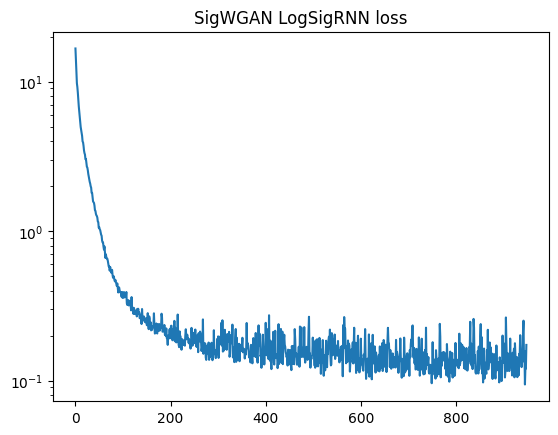

torch.Size([100, 30])


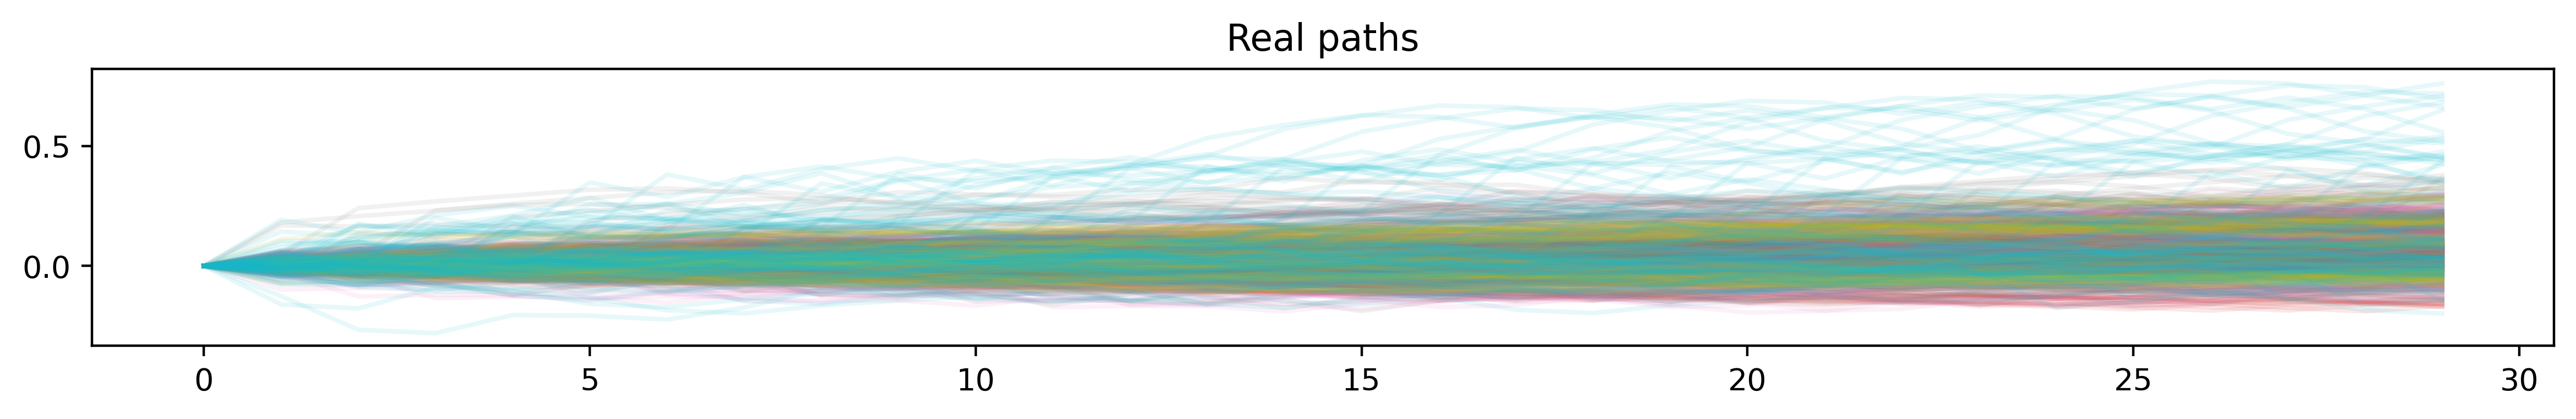

torch.Size([100, 30])


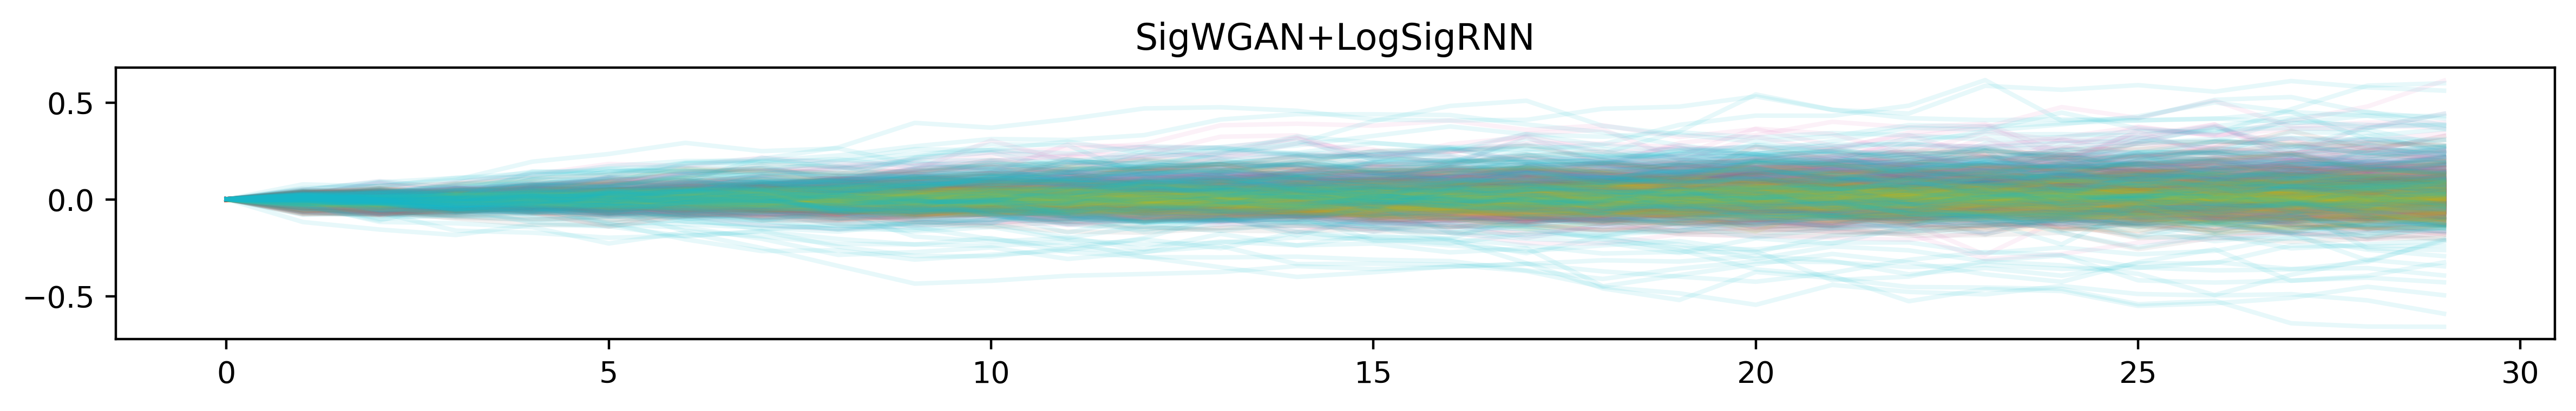

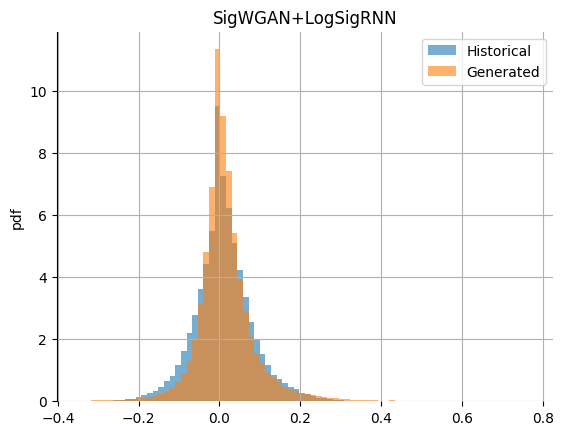

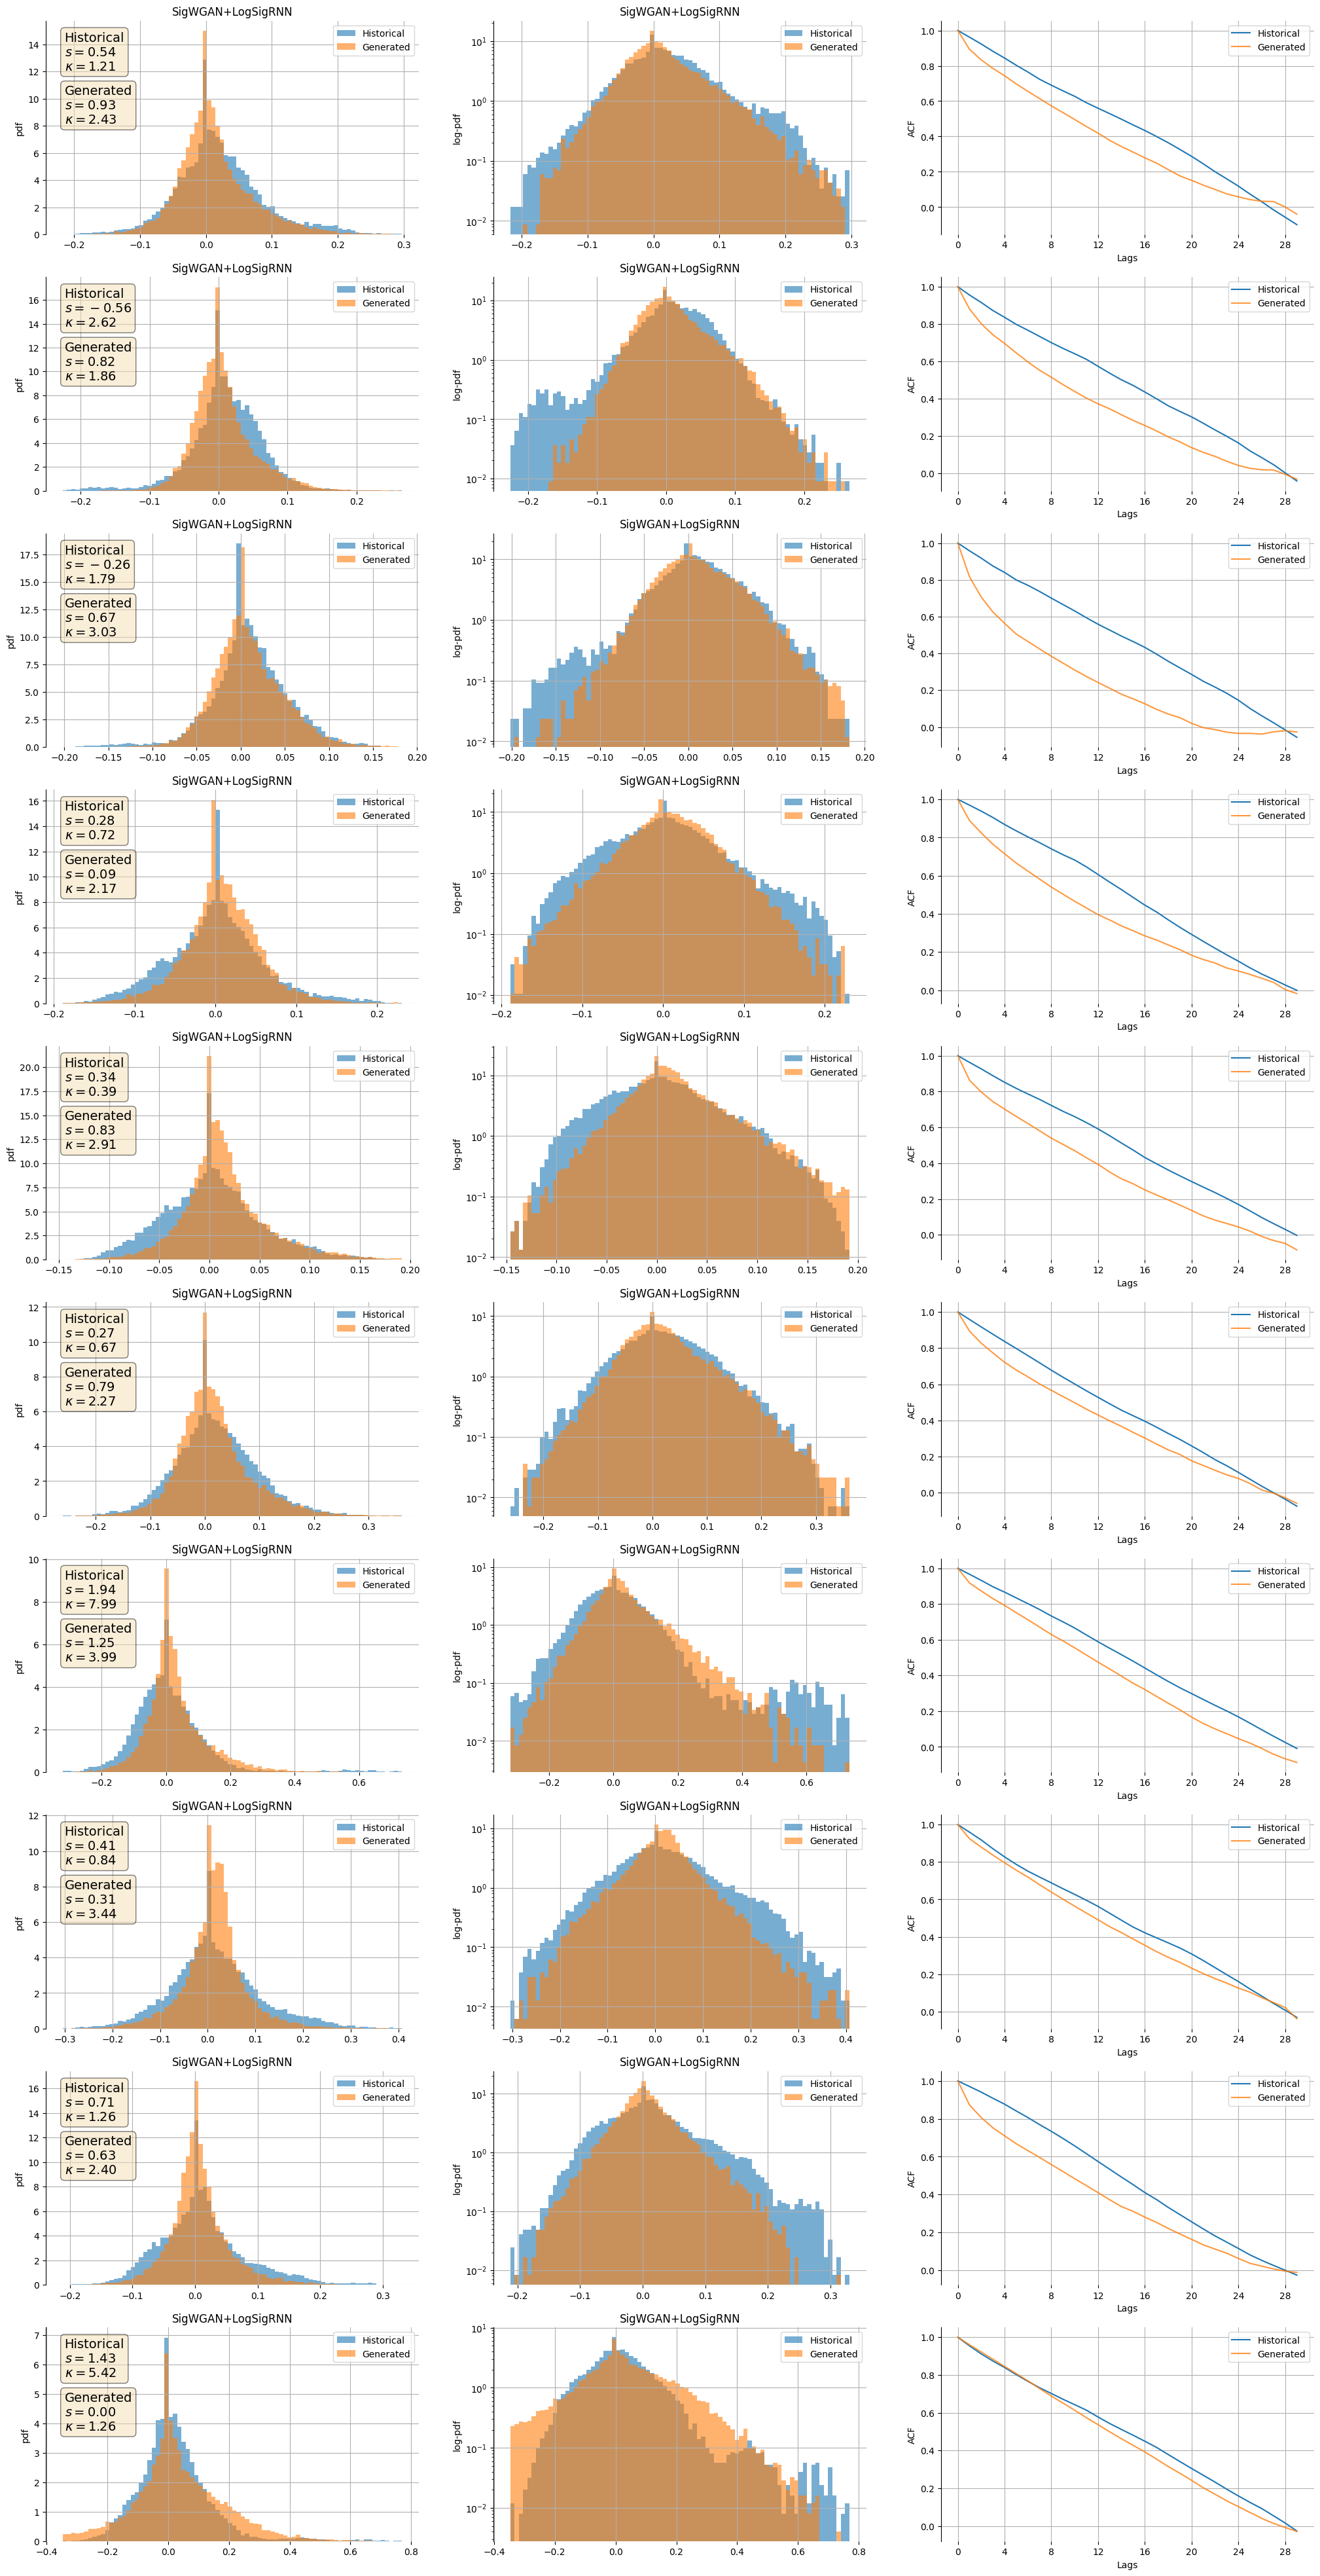

In [24]:
plt.plot(logsig_SigWGAN.losses_history['sig_w1_loss'])
plt.yscale('log')
plt.title("SigWGAN LogSigRNN loss")
plt.show()

plt.figure(figsize=(12, 2), dpi=400)
for i in range(x_real_dim):
    plt.plot(sigwgan.to_numpy(x_real_rolled[:100, :, i]).T, 'C%s' % i, alpha=0.1)
print(x_real_rolled[:100, :, i].shape)
plt.title("Real paths")
plt.tight_layout()
plt.show()

with torch.no_grad():
    x_fake = logsig_SigWGAN.G(600, data_config['window_size'], sigwgan_config['device'])

plt.figure(figsize=(12, 2), dpi=400)
for i in range(x_real_dim):
    plt.plot(sigwgan.to_numpy(x_fake[:100, :, i]).T, 'C%s' % i, alpha=0.1)
print(x_fake[:100, :, i].shape)
plt.title("SigWGAN+LogSigRNN")
plt.tight_layout()
plt.show()

sigwgan.compare_hists(sigwgan.to_numpy(x_real_rolled[:600]), sigwgan.to_numpy(x_fake), trainer="SigWGAN",
                      G="LogSigRNN")

sigwgan.plot_summary(x_fake=x_fake, x_real=x_real_rolled[:600], trainer="SigWGAN", G="LogSigRNN")